<a href="https://colab.research.google.com/github/ankojubhanuprakash/Machine_learning_practice/blob/main/uHack_Sentiments_2_0_Decode_Code_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense



In [3]:
# get the model
def get_model(n_inputs, n_outputs):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(n_inputs)))
  model.add(tf.keras.layers.Dense(64,kernel_initializer='he_uniform', activation='relu'))
  model.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform', activation='relu'))
  model.add(tf.keras.layers.Dense(10,kernel_initializer='he_uniform', activation='relu'))
  model.add(tf.keras.layers.Dense(n_outputs,kernel_initializer='he_uniform', activation='sigmoid'))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=tf.keras.metrics.BinaryAccuracy())
  return model

1.2 Check and Load GPU

In [4]:
print('TensorFlow version: {}'.format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found - On for CPU time!')
else:
    print('Found GPU at {}'.format(device_name))


TensorFlow version: 2.7.0
GPU device not found - On for CPU time!


# load data

In [5]:
train_df = pd.read_csv('train.csv')
train_df.shape

(6136, 14)

In [6]:
train_df.sample(5)

,Id,Review,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
784,784,These clamps really hold the line. No complain...,0,0,0,0,0,1,0,0,0,0,1,1
4906,4906,Anyone with a screen porch should have a roll ...,0,0,0,0,0,0,0,0,0,0,1,1
2592,2592,"Good quality, works well for what I need. Soli...",0,0,0,0,0,1,0,0,1,1,0,1
3815,3815,I have a number of small push-out windows with...,0,0,1,0,0,0,1,0,0,0,0,1
854,854,Delivered to my home quickly with no problems.,0,1,0,0,0,0,0,0,0,0,0,1


In [7]:
label_columns= train_df.drop(['Id','Review'],axis=1).columns
label_columns

Index(['Components', 'Delivery and Customer Support', 'Design and Aesthetics',
       'Dimensions', 'Features', 'Functionality', 'Installation', 'Material',
       'Price', 'Quality', 'Usability', 'Polarity'],
      dtype='object')

# Most of the data is imbalanced, so consider build a model for each label

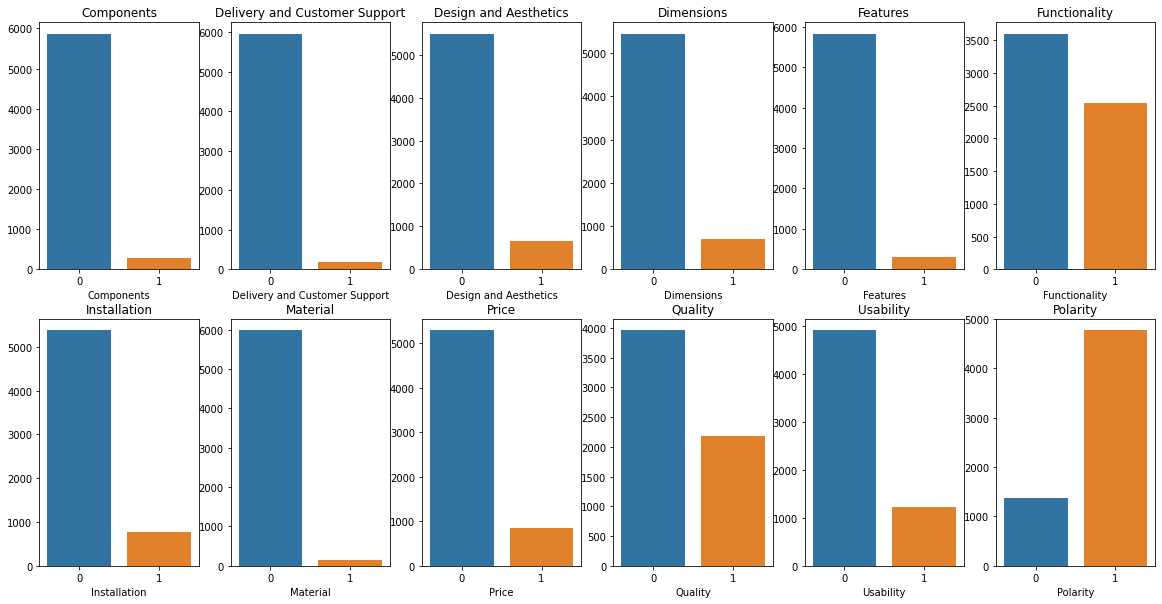

In [8]:
fig,axes=plt.subplots(2,6,figsize=(20,10))
i=0
for label in label_columns:
  if i<=5:
    lx=0
    ly=i
  else:
    lx=1
    ly=i-6
  i=i+1    
  temp=train_df.groupby(label)[label].count()
  ax=sns.barplot(x=temp.index,y=temp.values,ax=axes[lx,ly])
  ax.set(title=label)


In [9]:
test_df=pd.read_csv('test.csv')
test_df.shape

(2631, 14)

In [10]:
test_df.columns

Index(['Id', 'Review', 'Components', 'Delivery and Customer Support',
       'Design and Aesthetics', 'Dimensions', 'Features', 'Functionality',
       'Installation', 'Material', 'Price', 'Quality', 'Usability',
       'Polarity'],
      dtype='object')

# Clean text

In [11]:
def clean_text(text):
    chars = ',<.>/?;:"[{}]|)(*&^%$#@!=+-_0123456789'
    text = text.lower()
    for l in chars:
        text = text.replace(l, str(' '+l+' '))
        text = text.replace('  ',' ')
    return text

In [12]:
temp = pd.Series([clean_text(i) for i in train_df.loc[:,'Review'].tolist()])


In [13]:
train_df['mReview']=temp



In [14]:
train_df[['Review','mReview']].sample(5)

,Review,mReview
22,Love the ringâœ¨Clear pics/video. The ones I o...,love the ringâœ¨clear pics / video . the ones ...
354,I like the size and the light wate.,i like the size and the light wate .
4109,Comfortable. Knocked off a star because it sai...,comfortable . knocked off a star because it sa...
5039,"Nozzle works great, but I have only had it for...","nozzle works great , but i have only had it fo..."
1106,As expected. Great quality.,as expected . great quality .


,Review,mReview
2630,Easy to work with and install. We use this for...,easy to work with and install . we use this fo...
121,Pretty heavy duty. Quick release is nice.,pretty heavy duty . quick release is nice .
1550,Buy this if you want to pull the paint off you...,buy this if you want to pull the paint off you...
256,"Durable, nice fabric on well made cushions.","durable , nice fabric on well made cushions ."
1228,Bought this in July 2016. Was very happy with ...,bought this in july 2 0 1 6 . was very happy w...


# Convert Text data to tf hub 128 vector


In [16]:
#import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_hub as hub

hub_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
embed = hub.KerasLayer(hub_url)

In [18]:
train_df.columns
train_df.drop(['Id','Review','mReview'],axis=1)

,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,1,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,1,0,1
3,0,0,0,0,0,1,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6131,0,0,0,0,0,0,1,0,0,0,0,1
6132,0,0,0,0,0,0,0,0,0,1,1,1
6133,0,0,0,0,0,0,0,0,0,1,1,1
6134,0,0,0,0,0,0,0,0,1,0,0,0


# DEEP classifier

In [29]:
models=[]
scores=[]
model = get_model(128,1)
def train_a_model(column):
  acc=[]
  models=[]
  X_train,y_train=train_df['mReview'],train_df[column]
  skfolds = StratifiedKFold(n_splits=3, random_state=42,shuffle=True)
  for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = get_model(128,1)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    X_train_folds,X_test_fold=embed(X_train_folds ),embed(X_test_fold )
    clone_clf.fit(X_train_folds, y_train_folds,verbose=0, epochs=20)
    y_pred = clone_clf.predict(X_test_fold)
    y_pred = y_pred.round()
    acc.append(accuracy_score(y_test_fold, y_pred))
    models.append(clone_clf)
  return {column:models,'score':acc}  


In [32]:
knowledge={}
for i in train_df.drop(['Id','Review','mReview'],axis=1).columns:
  knowledge[i]=train_a_model(i)


In [60]:
temp = []
for i in knowledge:
  temp.append(np.mean(knowledge[i]['score']))


In [61]:
list(knowledge.keys())

['Components',
 'Delivery and Customer Support',
 'Design and Aesthetics',
 'Dimensions',
 'Features',
 'Functionality',
 'Installation',
 'Material',
 'Price',
 'Quality',
 'Usability',
 'Polarity']

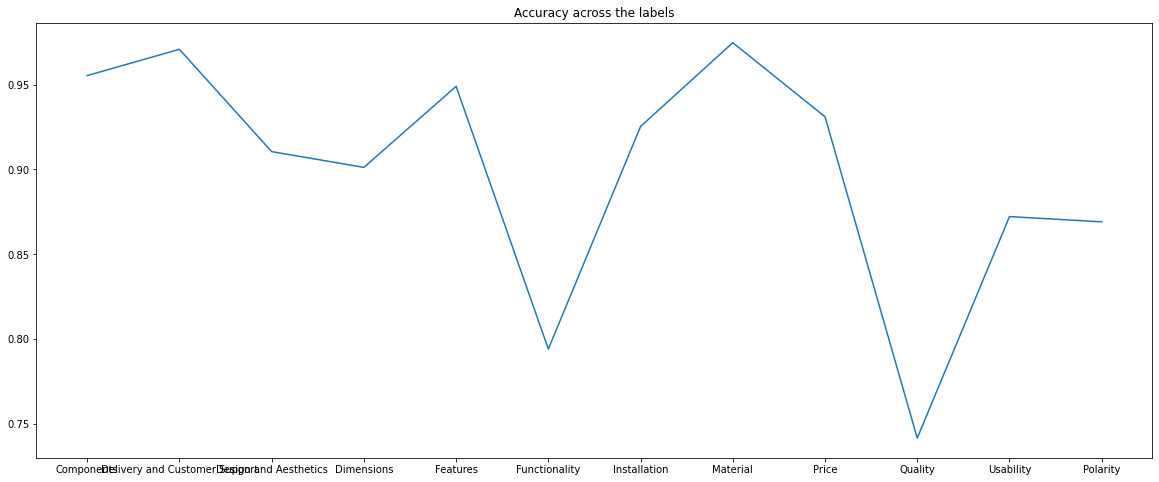

In [87]:
plt.subplots(figsize=(20,8))
plt.title('Accuracy across the labels')
plt.plot(list(knowledge.keys()),temp)


# SVM CLASSIFIEER

In [47]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [54]:

def train_a_model2(column):
  param_grid = {'kernel':('linear','poly', 'sigmoid',  'rbf'), 'C':[1, 10]}
  X_train,y_train=train_df['mReview'],train_df[column]
  X_train=embed(X_train).numpy()
  model = svm.SVC(gamma="auto")
  grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3, n_jobs=-1)
  grid_search.fit(X_train, y_train)

  return {column:grid_search.best_estimator_,'score':grid_search.best_score_}



 


In [55]:
knowledge2={}
for i in train_df.drop(['Id','Review','mReview'],axis=1).columns:
  knowledge2[i]=train_a_model2(i)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [89]:
temp2 = []
for i in knowledge2:
  temp2.append(knowledge2[i]['score'])


# SVM is performing good than DEEP classifier consistently

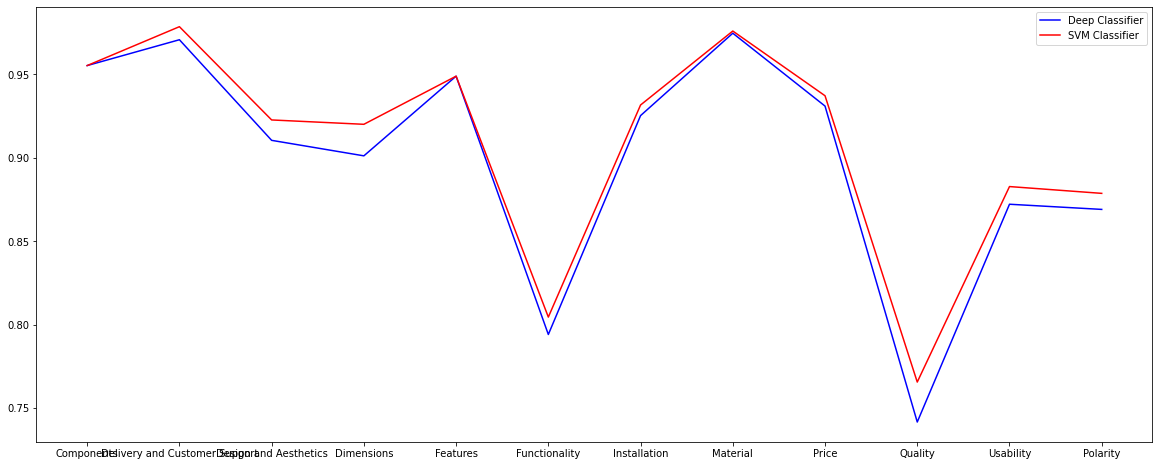

In [90]:
plt.subplots(figsize=(20,8))
plt.plot(list(knowledge.keys()),temp,color='blue',label='Deep Classifier')
plt.plot(list(knowledge.keys()),temp2,color='red',label='SVM Classifier')
plt.legend()

# Submission


In [72]:
test_df=pd.read_csv('test.csv')

test_df.shape

(2631, 14)

In [73]:
submission_df=pd.read_csv('submission.csv')
submission_df.sample(4)

,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
1979,0,0,0,0,0,0,0,0,0,0,0,0
1664,0,0,0,0,0,0,0,0,0,0,0,0
716,0,0,0,0,0,0,0,0,0,0,0,0
2464,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
temp2=pd.Series([clean_text(i) for i in test_df.loc[:,'Review'].tolist()])
test_df['mReview']=temp2
test_df[['Review','mReview']].sample(5)

,Review,mReview
1155,The camera is very easy to install. My son hel...,the camera is very easy to install . my son he...
2223,it covers a large area - and my grandchildren ...,it covers a large area - and my grandchildren ...
1885,Very easy to install & has been amazing,very easy to install & has been amazing
2250,Buy them and buy more than you think you'll ne...,buy them and buy more than you think you'll ne...
2109,This is great. it has three different settings...,this is great . it has three different setting...


In [76]:
X_test_embed=embed(test_df['mReview']).numpy()


In [77]:
for i in submission_df.columns:

Index(['Components', 'Delivery and Customer Support', 'Design and Aesthetics',
       'Dimensions', 'Features', 'Functionality', 'Installation', 'Material',
       'Price', 'Quality', 'Usability', 'Polarity'],
      dtype='object')

In [85]:
for i in knowledge2.keys():
  submission_df[i]=pd.Series(knowledge2[i][i].predict(X_test_embed))
  #print(knowledge2[i][i])

In [80]:
submission_df['Components']=pd.Series(knowledge2['Components']['Components'].predict(X_test_embed))

In [82]:
submission_df.describe()

,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
count,2631.0,2631.0,2631.0,2631.0,2631.0,2631.0,2631.0,2631.0,2631.0,2631.0,2631.0,2631.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
submission_df.describe()

,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
count,2631.0,2631.000000,2631.000000,2631.000000,2631.0,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000
mean,0.0,0.017484,0.049791,0.052452,0.0,0.388065,0.100342,0.004181,0.111365,0.278981,0.145952,0.799316
std,0.0,0.131090,0.217554,0.222978,0.0,0.487402,0.300513,0.064537,0.314643,0.448584,0.353125,0.400588
min,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
submission_df.to_csv('submission2.csv')